In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST Dataset

In [2]:
# https://www.kaggle.com/datasets/hojjatk/mnist-dataset

#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

#
# Set file paths based on added MNIST Datasets
#
input_path = './input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train_, y_train_), (X_test_, y_test_) = mnist_dataloader.load_data()

In [3]:
# output is a normal array. change it to np array.

X_train = np.array(X_train_)
y_train = np.array(y_train_)

X_test = np.array(X_test_)
y_test = np.array(y_test_)

# Turn format into (768, samples)
X_train = X_train.reshape(X_train.shape[0], -1).T
X_test = X_test.reshape(X_test.shape[0], -1).T

def one_hot(y):
    n_values = np.max(y) + 1
    return np.eye(n_values)[y].T
    
y_train = one_hot(y_train)
y_test = one_hot(y_test)

# Functions

In [4]:
def ReLU(x):
    return np.maximum(x, 0)


def dReLU(x):
    return x > 0


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0))
    return e_x / e_x.sum(axis=0)


def cross_entropy(y, y_pred):
    eps = np.finfo(float).eps
    loss = -np.sum(y * np.log(y_pred + eps)) / y.shape[1]
    return loss


def init_parameters(layers):
    np.random.seed(637)
    parameters = {}

    for l in range(1, len(layers)):
        layer_size, init_method = layers[l]
        prev_layer_size, _ = layers[l-1]
        
        if init_method == "he":
            limit = np.sqrt(6 / prev_layer_size)
            parameters['W' + str(l)] = np.random.uniform(-limit, limit, (layer_size, prev_layer_size))
        elif init_method == "xavier":
            limit = np.sqrt(6 / (layer_size + prev_layer_size))
            parameters['W' + str(l)] = np.random.uniform(-limit, limit, (layer_size, prev_layer_size))
        elif init_method == "lecun":
            parameters['W' + str(l)] = np.random.randn(layer_size, prev_layer_size) * np.sqrt(1 / prev_layer_size)

        parameters['b' + str(l)] = np.zeros((layer_size, 1))
        
    return parameters


def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    caches = [(A1, Z1), (A2, Z2)]
    
    return caches


def backward_propagation(X, y, caches, parameters):
    m = X.shape[1]
    grads = {}

    A2, Z2 = caches[1]
    A1, Z1 = caches[0]

    # softmax
    dZ2 = A2 - y
    grads['dW2'] = np.dot(dZ2, A1.T) / m
    grads['db2'] = np.sum(dZ2) / m

    # relu
    dZ1 = np.multiply(np.dot(parameters['W2'].T, dZ2), dReLU(Z1))
    grads['dW1'] = np.dot(dZ1, X.T) / m
    grads['db1'] = np.sum(dZ1) / m

    return grads

def init_adam_parameters(parameters):
    v = {}
    s = {}

    for l in range(1, len(parameters) // 2 + 1):
        v['dW' + str(l)] = np.zeros((parameters['W' + str(l)]).shape)
        v['db' + str(l)] = np.zeros((parameters['b' + str(l)]).shape)
        s['dW' + str(l)] = np.zeros((parameters['W' + str(l)]).shape)
        s['db' + str(l)] = np.zeros((parameters['b' + str(l)]).shape)

    return v, s


def update_adam_parameters(parameters, grads, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    v_corrected = {}
    s_corrected = {}

    for l in range(1, len(parameters) // 2 + 1):
        dw_idx = 'dW' + str(l)
        db_idx = 'db' + str(l)
        
        v[dw_idx] = beta1 * v[dw_idx] + (1 - beta1) * grads[dw_idx]
        v[db_idx] = beta1 * v[db_idx] + (1 - beta1) * grads[db_idx]

        v_corrected[dw_idx] = v[dw_idx] / (1 - beta1 ** t)
        v_corrected[db_idx] = v[db_idx] / (1 - beta1 ** t)

        s[dw_idx] = beta2 * s[dw_idx] + (1 - beta2) * (np.square(grads[dw_idx]))
        s[db_idx] = beta2 * s[db_idx] + (1 - beta2) * (np.square(grads[db_idx]))

        s_corrected[dw_idx] = s[dw_idx] / (1 - beta2 ** t)
        s_corrected[db_idx] = s[db_idx] / (1 - beta2 ** t)

        parameters['W' + str(l)] -= learning_rate * v_corrected[dw_idx] / (np.sqrt(s_corrected[dw_idx]) + epsilon)
        parameters['b' + str(l)] -= learning_rate * v_corrected[db_idx] / (np.sqrt(s_corrected[db_idx]) + epsilon)

    return parameters, v, s


def compute_accuracy(y, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=0)
    y_true_labels = np.argmax(y, axis=0)
    return np.mean(y_pred_labels == y_true_labels)


def create_mini_batches(X, y, batch_size=100):
    np.random.seed(637)

    m = X.shape[1]
    
    indices = np.arange(m)
    np.random.shuffle(indices)

    for idx in range(0, m, batch_size):
        excerpt = indices[idx:idx + batch_size]
        yield X[:, excerpt], y[:, excerpt]


def train(X_train, y_train, X_test, y_test, layers, num_epochs=100, batch_size=100, learning_rate=0.001):
    parameters = init_parameters(layers)
    v, s = init_adam_parameters(parameters)
    t = 1
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        for mini_batch in create_mini_batches(X_train, y_train, batch_size):
            X_batch, y_batch = mini_batch
            caches = forward_propagation(X_batch, parameters)
            grads = backward_propagation(X_batch, y_batch, caches, parameters)
            parameters, _, _ = update_adam_parameters(parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8)
            t += 1

        # Compute train and test losses and accuracy
        train_cache = forward_propagation(X_train, parameters)
        train_pred = train_cache[1][0]
        train_loss = cross_entropy(y_train, train_pred)
        train_acc = compute_accuracy(y_train, train_pred)
        
        test_cache = forward_propagation(X_test, parameters)
        test_pred = test_cache[1][0]
        test_loss = cross_entropy(y_test, test_pred)
        test_acc = compute_accuracy(y_test, test_pred)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch + 1}/{num_epochs} -- train_loss: {train_loss:.6f}, train_acc: {train_acc:.6f} - test_loss: {test_loss:.6f}, test_acc: {test_acc:.6f}")

    return parameters, train_losses, test_losses, train_accuracies, test_accuracies

In [5]:
learning_rate = 0.001
layers = [
    (784, "none"), # input
    (64, "he"), # relu
    (10, "xavier") # softmax
]

parameters, train_losses, test_losses, train_accuracies, test_accuracies = train(
    X_train, y_train, X_test, y_test, layers, num_epochs=100, batch_size=100, learning_rate=learning_rate
)

Epoch 1/100 -- train_loss: 0.673414, train_acc: 0.835583 - test_loss: 0.690007, test_acc: 0.836300
Epoch 2/100 -- train_loss: 0.447898, train_acc: 0.882417 - test_loss: 0.503888, test_acc: 0.877800
Epoch 3/100 -- train_loss: 0.354744, train_acc: 0.905067 - test_loss: 0.436215, test_acc: 0.903500
Epoch 4/100 -- train_loss: 0.277440, train_acc: 0.923150 - test_loss: 0.388467, test_acc: 0.915100
Epoch 5/100 -- train_loss: 0.232755, train_acc: 0.934667 - test_loss: 0.311085, test_acc: 0.926300
Epoch 6/100 -- train_loss: 0.222771, train_acc: 0.937150 - test_loss: 0.305437, test_acc: 0.929700
Epoch 7/100 -- train_loss: 0.194712, train_acc: 0.945267 - test_loss: 0.292986, test_acc: 0.936900
Epoch 8/100 -- train_loss: 0.195226, train_acc: 0.945150 - test_loss: 0.276706, test_acc: 0.935900
Epoch 9/100 -- train_loss: 0.190564, train_acc: 0.949167 - test_loss: 0.256669, test_acc: 0.938300
Epoch 10/100 -- train_loss: 0.169908, train_acc: 0.950833 - test_loss: 0.238112, test_acc: 0.941700
Epoch 11/

## h) Plot another figure that demonstrates overfitting to the training data, so that the test loss increases while the training loss continues to decline.

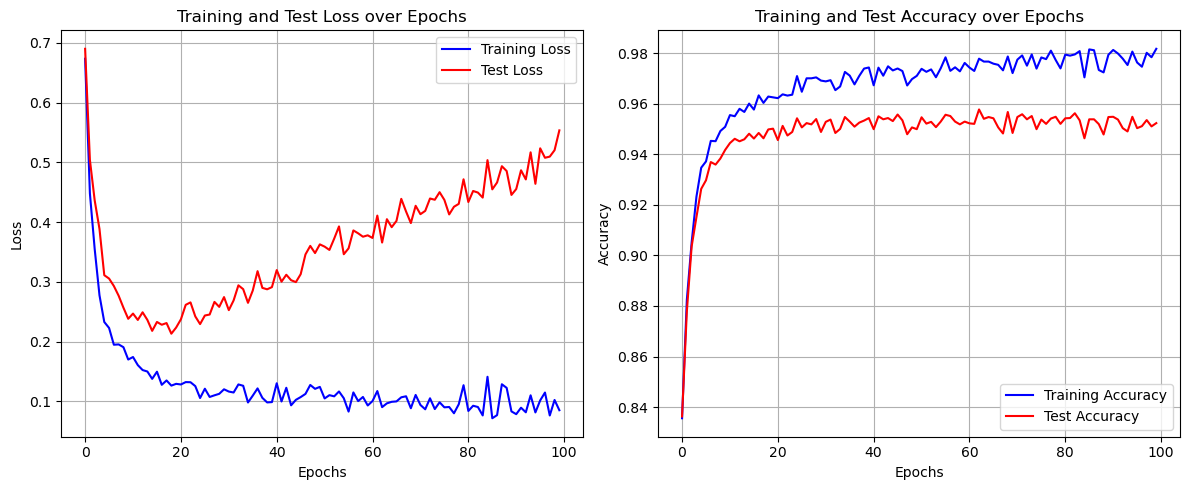

In [6]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(len(train_losses))
    
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)